问题三：
根据$y = x^{3} + x$，以适当的额等间距弧长采样，计算这些点的曲率，然后以采样的曲率为基础，构建数学模型，重构平面曲线，并分析重构曲线与原始曲线出现误差的原因。 

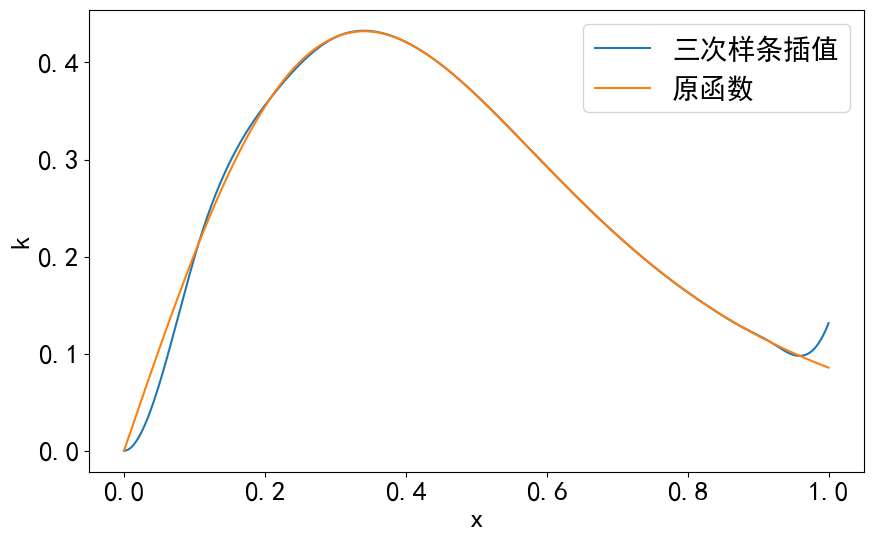

In [10]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
# 获取当前操作系统
import platform
sysstr = platform.system()
if(sysstr =="Windows"):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
elif(sysstr == "Darwin"):
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
def f(x):
    return x**3 + x
def ds(x):
    return np.sqrt(1 + (3*x**2 + 1)**2)
def df(x):
    return 3*x**2 + 1
def d2f(x):
    return 6*x 
s,err = scipy.integrate.quad(ds, 0, 1) # 积分计算弧长
# 等弧长采样
points = 15
# 每段弧的长度
l = s / points
x = [0]
cur_length = 0
x0 = 0
while len(x) < points:
    x0 += 0.0001
    cur_length = scipy.integrate.quad(ds, x[-1], x0)[0] # 计算当前弧长
    if abs(cur_length - l) < 1e-3:
        x.append(x0)
y = [f(i) for i in x]
# 计算各个采样点的曲率
k = []
for i in range(len(x)):
    k.append(abs(d2f(x[i]) / (1 + df(x[i])**2)**1.5))
# 三次样条插值重构每个采样点周围的曲率
cs = scipy.interpolate.CubicSpline(x, k, bc_type='clamped') # 三次样条插值
# 生成更多点用于插值
x_interp = np.linspace(0, 1, 1000)
k_interp = cs(x_interp)
# 计算原函数中各个点的曲率
k0 = []
for i in x_interp:
    k0.append(abs(d2f(i) / (1 + df(i)**2)**1.5))
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_interp, k_interp, label='三次样条插值曲线')  
plt.plot(x_interp, k0, label='原曲线')
plt.xlabel('x', fontsize=20)
plt.ylabel('k', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

# 斜率递推算法重建曲线  
$k_{n+1} = \tan [\kappa _{n}\Delta s_{n}+\tan^{-1}(k_{n})]$  
$\Delta x = \frac{\Delta s_{n} }{\sqrt {1+k_n ^ {2}}} $  
$\Delta y = \frac{k_{n} \Delta s_{n} }{\sqrt {1+k_n ^ {2}}}$  
根据实际情况，一般会知道要重构曲线的原点，原点斜率，弧长  
设置初始点为原点，初始斜率设定为1，每两个采样点（包含插值点）间的弧长 = 总长度 / 点的总数，已知采样点和插值出的各个点的曲率，以此重构曲线

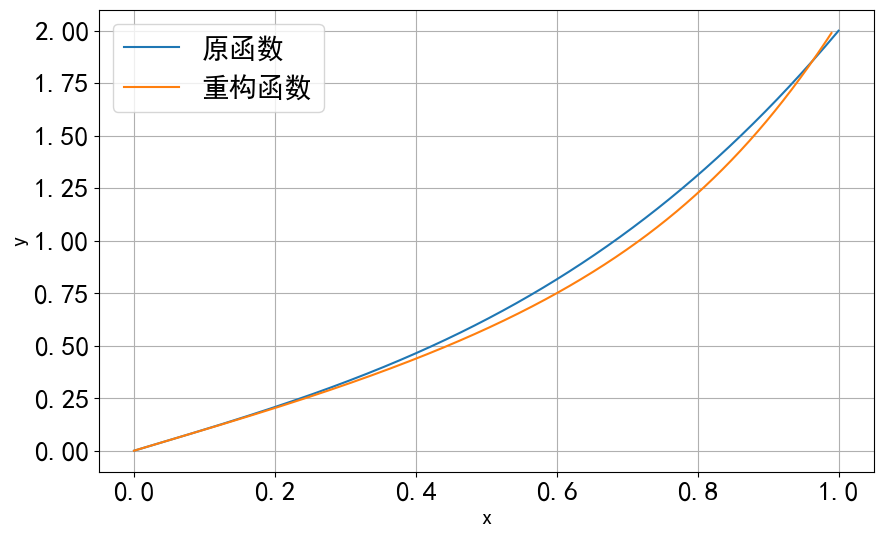

In [11]:
# 依据初始条件和上式计算每个点的斜率
ds = s / 1000 # 每段弧长
tan0 = df(0) # 初始斜率
tans = [tan0]
for i in range(len(x_interp)): # 递推计算每个点的斜率
    next_tan = np.tan(k_interp[i] * ds + np.arctan(tans[-1]))
    tans.append(next_tan)
# 以原点为起点，递推计算每个点的坐标
pts = [(0, 0)]
for i in range(len(x_interp)):
    nx = pts[-1][0] + (ds / np.sqrt(1 + tans[i]**2))
    ny = pts[-1][1] + (ds * tans[i] / np.sqrt(1 + tans[i]**2))
    pts.append((nx, ny))
# 修正最后一个点的坐标
pts = pts[:-1]
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_interp,[f(i) for i in x_interp], label='原曲线')
plt.plot([i[0] for i in pts], [i[1] for i in pts], label='重构曲线')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)
plt.grid(True)
plt.show()

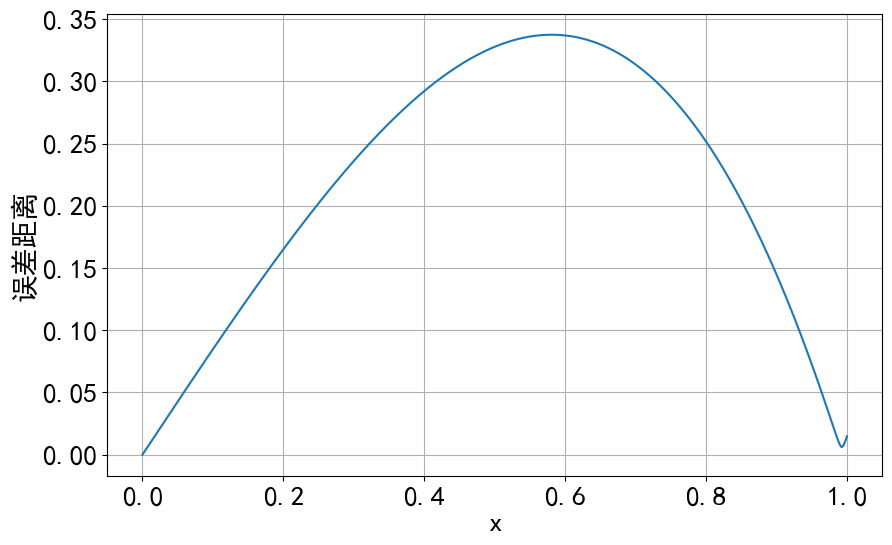

In [12]:
# 计算每个点的误差
err = []
for i in range(len(pts)):
    err.append(np.sqrt((pts[i][0] - x_interp[i])**2 + (pts[i][1] - f(x_interp[i]))**2)) # 计算欧氏距离
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_interp, err)
plt.xlabel('x', fontsize=20)
plt.grid(True)
plt.ylabel('误差距离', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# 平面坐标变换(暂未实现)  
采用运动坐标思想，由相邻两个点的坐标关系，通过变换得到当前点相对上上个点的坐标，迭代可得所有点在固定坐标系下的绝对坐标，进而实现曲线重建。  

完成一次变换的过程：  
$$
\begin{bmatrix}
 x\\
 y\\
1 

\end{bmatrix} = \begin{bmatrix}
  1&  &x_{i} \\
  & 1 &y_{i} \\
  &  &1
\end{bmatrix}\begin{bmatrix}
  \cos\theta _{i} &  -\sin \theta _{i} & \\
  \sin \theta_{i}&  \cos \theta _{i}& \\
  &  & 1
\end{bmatrix}\begin{bmatrix}
 x_{i+1}\\
 y_{i+1}\\
1
\end{bmatrix}  
$$
又根据几何关系，每个点相对上一个点的坐标关系为：  

$$
x_{i} = \rho _{i} - \rho _{i} \cos \frac{s_{i}}{\rho _{i}}
$$  

$$
y_{i} = \rho _{i} \sin \frac{s_{i}}{\rho _{i}} 
$$

且$$\theta = s \times \kappa $$

In [13]:
# 以原点作为初始点，构造每个点相对上一个点的坐标
# pts2 = [(0, 0)]
# k_interp[0] = k_interp[1]
# for i in range(len(x_interp)):
#     nx = pts2[-1][0] + (1 / k_interp[i]) - (1 / k_interp[i]) * np.cos(k_interp[i] * ds)
#     ny = pts2[-1][1] + (1 / k_interp[i]) * np.sin(k_interp[i] * ds)
#     pts2.append((nx, ny))
# # 修正最后一个点的坐标
# pts2 = pts2[:-1]
# print(pts2)
# 利用矩阵变换将这些点转换到原函数坐标系中
# thetas = [ds * k_interp[i] for i in range(len(k_interp))]
# original_pts = [pts2[0], pts2[1]]
# for i in range(2,1000):
#     cnt = i
#     for _ in range(i - 1):
#         pre_point = pts2[cnt - 1]
#         ppre_point = pts2[cnt - 2]
#         m1 = np.array([[1,0,ppre_point[0]],[0,1,ppre_point[1]],[0,0,1]])
#         m2 = np.array([[np.cos(thetas[cnt]),-np.sin(thetas[cnt]),0],[np.sin(thetas[cnt]),np.cos(thetas[cnt]),0],[0,0,1]])
#         m3 = np.array([[pre_point[0]], [pre_point[1]], [1]])
#         new_point = m1 @ m2 @ m3
#         cnt -= 1
#     original_pts.append((new_point[0][0], new_point[1][0]))


# 切角递推算法  
$$ \beta (s) = \int \kappa(s)\mathrm{d}s $$  
$$ \kappa = as^3+bs^2+cs+d $$

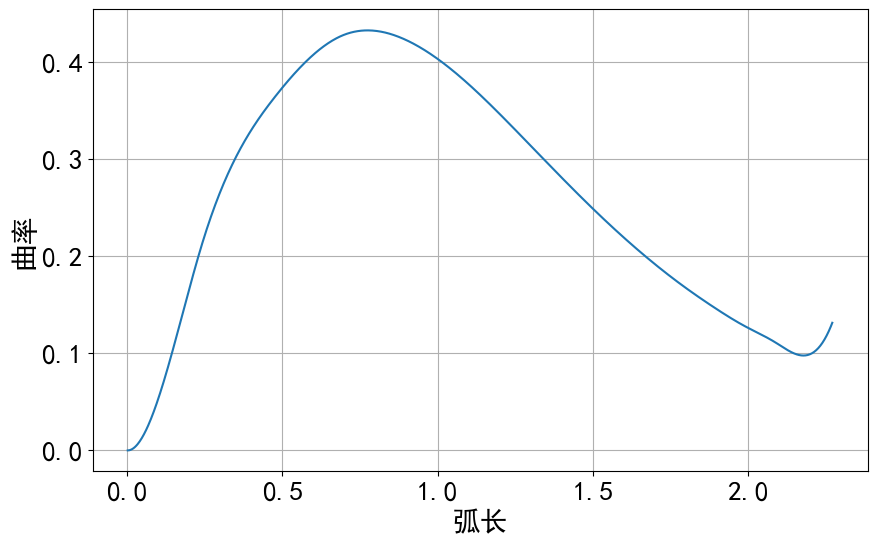

In [14]:
# 切角递推算法
# 首先拟合弧长和曲率的关系,假设曲率是均匀变化的
ori_x = [ds * i for i in range(1, 1001)]
ori_y = [k_interp[i] for i in range(1000)]
# 绘制曲率-弧长关系图
plt.figure(figsize=(10, 6))
plt.plot(ori_x, ori_y)
plt.xlabel('弧长', fontsize=20)
plt.ylabel('曲率', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()





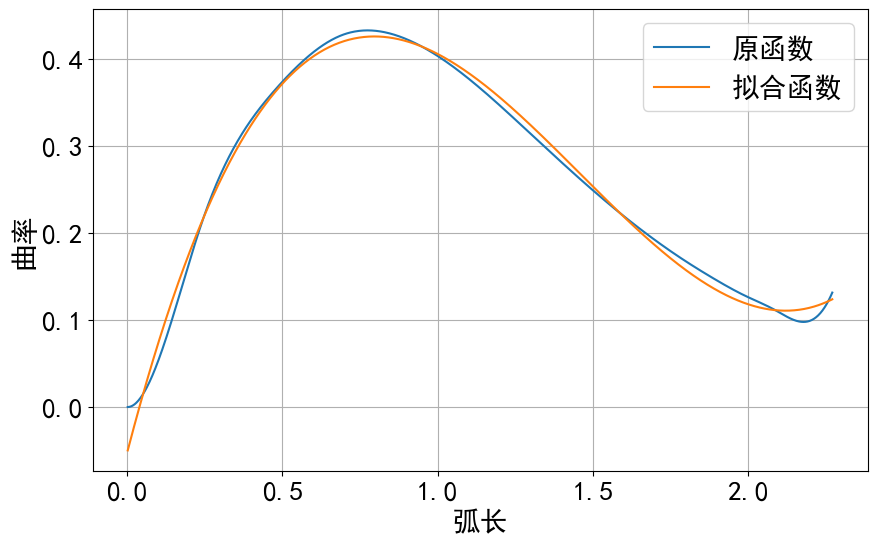

In [15]:
# 采用三次函数进行拟合，并评估拟合效果
def fit_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d
popt, pcov = scipy.optimize.curve_fit(fit_func, ori_x, ori_y)
# 计算拟合误差  
err = []
for i in range(1000):
    err.append(abs(fit_func(ori_x[i], *popt) - ori_y[i]))
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(ori_x, ori_y, label='原曲线')
plt.plot(ori_x, [fit_func(i, *popt) for i in ori_x], label='拟合曲线')
plt.xlabel('弧长', fontsize=20)
plt.ylabel('曲率', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()


In [16]:
# 输出拟合参数
print(popt)
# 输出拟合误差
print(np.mean(err))


[ 0.27134882 -1.18719216  1.37449076 -0.05296015]
0.007395080545742632


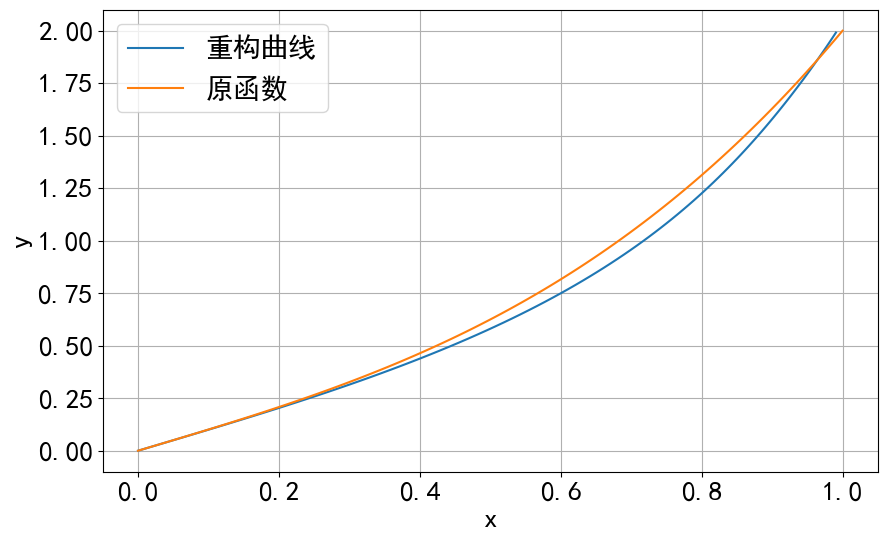

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
def ori_func(x):
    return x**3 + x
# 定义弧长-曲率关系
def kappa(s):
    return popt[0] * s**3 + popt[1] * s**2 + popt[2] * s + popt[3]
# 定义初始条件
theta0 = np.pi / 4  # 初始角度
x0, y0 = 0, 0  # 初始点

# 定义弧长范围
s = np.linspace(0, 2.27073, 100)

# 计算切线角度 theta(s)
theta = cumtrapz(kappa(s), s, initial=0) + theta0

# 计算参数方程 x(s) 和 y(s)
x = x0 + cumtrapz(np.cos(theta), s, initial=0)
y = y0 + cumtrapz(np.sin(theta), s, initial=0)

# 绘制曲线
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='重构曲线')
plt.plot([i for i in np.linspace(0,1,100)],[ori_func(i) for i in np.linspace(0,1,100)], label='原曲线')
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()


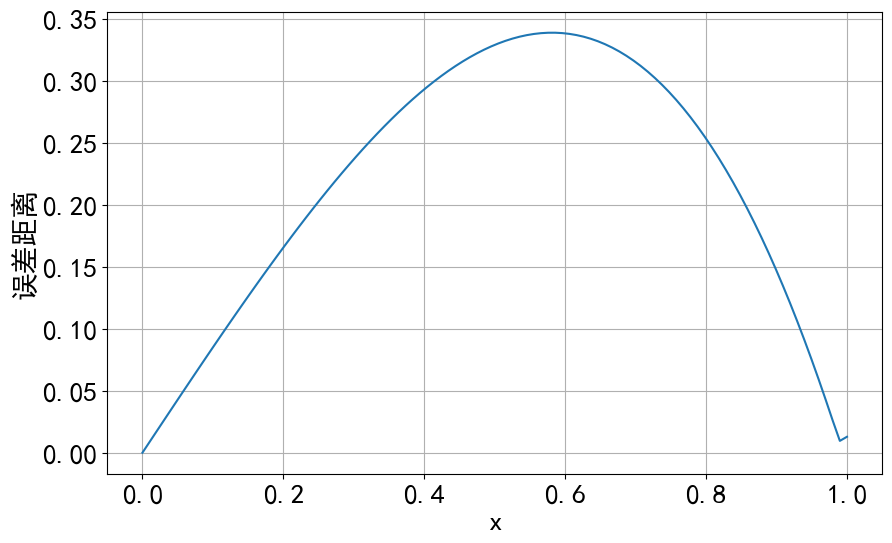

In [18]:
# 计算每个x处，重构曲线和原函数的误差
err = []
for i in range(len(x)):
    err.append(np.sqrt((x[i] - np.linspace(0,1,100)[i])**2 + (y[i] - ori_func(np.linspace(0,1,100)[i]))**2))
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0,1,100), err)
plt.xlabel('x', fontsize=20)
plt.grid()
plt.ylabel('误差距离', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
